In [2]:

import numpy as np                       # mathematical methods
from scipy.optimize import leastsq
from scipy import stats                  # contains some fitting routines
from scipy import signal
from scipy.signal import chirp
from scipy.signal import argrelextrema
import pandas as pd

from peakdetection import detect_peaks

#import matplotlib.pylab as plt
from matplotlib import pyplot as plt     # plotting methods within notebook

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator


%matplotlib inline


plot = True
#plot = False

def kepler(x, I) : #inputs: resting potential v0,u0 , current[certaintime]
    GNa = 120.0
    GK = 36.0
    GL = 0.3
    ENa = +50.0
    EK = -77.0
    EL = -54.384
    C = 1.0 
    PT = 1.0

    V = x[0] 
    U = x[1]

    z = (U+55.0)/10.0
    ns = 1.0/(1.0+12.5*np.exp(-(U+65.0)/80.0)*0.1*(1.0 if abs(z) < 1e-4 else (1.0-np.exp(-z))/z))
    # ns = 1.0/(1.0+12.5*np.exp(-(U+65.0)/80.0)*(1.0-np.exp(-(U+55.0)/10.0))/(U+55.0))

    dU = 0.001
    z = (U+dU+55.0)/10.0
    nsU = 1.0/(1.0+12.5*np.exp(-(U+dU+65.0)/80.0)*0.1*(1.0 if abs(z) < 1e-4 else (1.0-np.exp(-z))/z))
    # nsU = 1.0/(1.0+12.5*np.exp(-(U+dU+65.0)/80.0)*(1.0-np.exp(-(U+dU+55.0)/10.0))/(U+dU+55.0))

    z = (V+55.0)/10.0
    nsV = 1.0/(1.0+12.5*np.exp(-(V+65.0)/80.0)*0.1*(1.0 if abs(z) < 1e-4 else (1.0-np.exp(-z))/z))
    # nsV = 1.0/(1.0+12.5*np.exp(-(V+65.0)/80.0)*(1.0-np.exp(-(V+55.0)/10.0))/(V+55.0))

    z = (V+40.0)/10.0
    ms = 1.0/(1.0+40.0*np.exp(-(V+65)/18.0)*0.1*(1.0 if abs(z) < 1e-4 else (1.0-np.exp(-z))/z))
    # ms = 1.0/(1.0+40.0*np.exp(-(V+65)/18.0)*(1.0-np.exp(-(V+40.0)/10.0))/(V+40.0))

    dV = 0.001
    z = (V+dV+40.0)/10.0
    msV = 1.0/(1.0+40.0*np.exp(-(V+dV+65)/18.0)*0.1*(1.0 if abs(z) < 1e-4 else (1.0-np.exp(-z))/z))
    # msV = 1.0/(1.0+40.0*np.exp(-(V+dV+65)/18.0)*(1.0-np.exp(-(V+dV+40.0)/10.0))/(V+dV+40.0))

    hs = 1.0/(1.0+1.0/(0.07*np.exp(-(U+65)/20.0)*(np.exp(-(U+35.0)/10.0)+1.0)))
    hsU = 1.0/(1.0+1.0/(0.07*np.exp(-(U+dU+65)/20.0)*(np.exp(-(U+dU+35.0)/10.0)+1.0)))
    hsV = 1.0/(1.0+1.0/(0.07*np.exp(-(V+65)/20.0)*(np.exp(-(V+35.0)/10.0)+1.0)))

    dgNa = GNa*ms*ms*ms*(V-ENa)
    dgK = GK*4.0*ns*ns*ns*(V-EK)
    th = 1.0/(0.07*np.exp(-(V+65.0)/20.0)+1.0/(np.exp(-(V+35.0)/10.0)+1.0))

    z = (V+55.0)/10.0
    tn = 1.0/(0.125*np.exp(-(V+65)/80.0)+0.1*(1.0 if abs(z) < 1e-4 else z/(1.0-np.exp(-z))))
    # tn = 1.0/(0.125*np.exp(-(V+65)/80.0)+0.01*(V+55.0)/(1.0-np.exp(-(V+55.0)/10.0)))

    z = (V+40.0)/10.0
    # tm = 1.0/(4.0*np.exp(-(V+65.0)/18.0)+0.1*(V+40.0)/(1.0-np.exp(-(V+40.0)/10.0)))
    tm = 1.0/(4.0*np.exp(-(V+65.0)/18.0)+(1.0 if abs(z) < 1e-4 else z/(1.0-np.exp(-z))))

    a = dgNa*(hsV-hs)/th+dgK*(nsV-ns)/tn
    b = dgNa*(hsU-hs)/dU+dgK*(nsU-ns)/dU

    g = GL + GK*ns*ns*ns*ns + GNa*ms*ms*ms*hs
    dFdVm = GNa*3.0*ms*ms*hs*(V-ENa)*(msV-ms)/dV
    alpha = 0.5*(C/tm+g - np.sqrt((C/tm+g)*(C/tm+g)-4.0*(g+dFdVm)*C/tm))/(g+dFdVm)

    GNaGates = GNa*ms*ms*ms*hs
    GKGates = GK*ns*ns*ns*ns

    INa = GNaGates*(V-ENa)
    IK = GKGates*(V-EK)
    IL = GL*(V-EL)

    dVdt = alpha * (-INa-IK-IL+I)/C   
    dUdt = a/b                         

    return dVdt, dUdt               
#returns changes in V and U for a certain v0 and u0 and current[time k]

#HH-style

def trajectory(derivative, tmin, tmax, I0, I1, v0, u0) :
    deltat = 0.01
    time = np.arange(tmin, tmax, deltat)
    # = [tmin, tmin+deltat, tmin+2deltat, ..., tmax - deltat], len(time) = (tmax - tmin) / deltat
    x = np.zeros((2, len(time)))
    # 2-dim Array of len(time)x 0's x2
    current = np.zeros(len(time))
    # 1-dim Array of len(time)x 0's
    current[time<0.0] = I0
    # set current below time = 0 on I0
    current[time>=0.0] = I1
    # set current beginning at time = 0 on I1
    xx = [ v0, u0 ]
    for k in range(len(time)) :
        dVdt, dUdt = derivative(xx, current[k]) #gets changes in V and U for a certain current[time k]
        xx[0] += dVdt*deltat 
        xx[1] += dUdt*deltat #add these changes to the former values v0, u0
        x[0,k] = xx[0] #stores all changes in V ...
        x[1,k] = xx[1] #stores all changes in U untill tmax for every timestep
    return time, current, x #returns timearray, currentarray and updated v,u-array


In [ ]:
print('hello')

In [3]:
def spikeresponse_trajec(derivative, I0, I1, freq, delta) :
    
    
    #tmax = 10000.0
    #tmax = 600.0
    tmax = 2000.0
    dt = 0.01
    time = np.arange(int(tmax/dt))*dt #[ 0, dt, 2dt, ... , (tmax / dt) dt = tmax]
    thresh = -20.0
    
    
    taus = 1.0 #changed taus as an input
    if delta:
        stime = np.arange(0.0, .025 * taus, dt)
    else:
        stime = np.arange(0.0, 1.5 * taus, dt)
    spulse = (I1-I0) + 0 * stime

    rates = [] #creates empty array
    dp = 1000.0/freq          #period = distance of pulses (= 1000 ms / frequency)
    pulses = np.arange(0.0, tmax-(1.5*taus), dp) #pulses occuring between 0 and tmax-8taus with dist. dp
    current = np.zeros(len(time)) + I0 #current = I0 for all the time
    for pt in pulses: #loop through all the pulse-times
        current[int(pt/dt):int(pt/dt)+len(spulse)] += spulse
            #add spulse (growth) while current is between pt and pt + 8tau/dt (= back at rest. pot)
            # = adds a full spulse on the current to the next pulse (dimensions are perfectly fit)
    
    eigenperiod = int(1000.0/84/dt)
    
    t, x, i = trajectory(derivative, -100.0, tmax, I0, current, -65.0, -65.0)

    return t, x, i

-61.7315502329
-61.7315242527


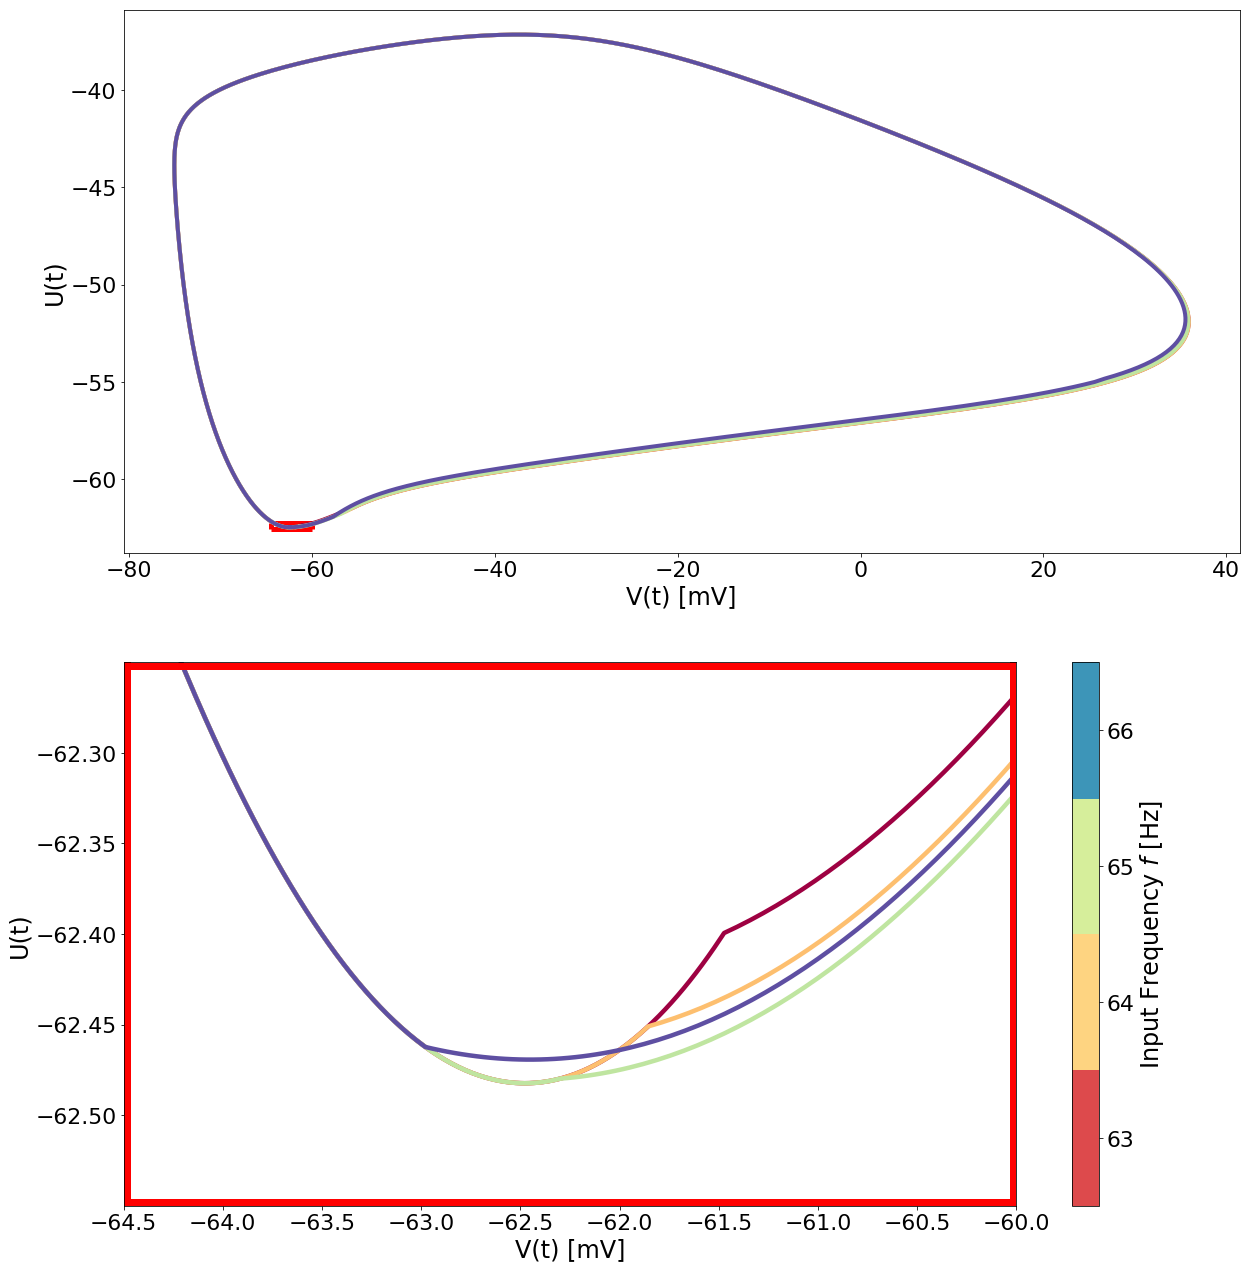

In [11]:


eigenfreq = 84 #TO DO
eigenperiod = 1000.0 / eigenfreq

l11 = True
l31 = False
l21 = False

dt = .01

if l11:
    freqs = np.arange(63, 67, 1) #for 8.0 and 130.1
if l31:
    freqs = np.arange(83, 95, 1)
if l21:
    freqs = np.arange(101, 107, 1) #for 130.1
    #freqs = np.arange(101, 108, 1) #for 8.0

ymax = -58.5
#xmax = -55.5
xmax = -54
xmin = -70
ymin = -62.75



min, max = (np.min(freqs), np.max(freqs))
mymap = plt.get_cmap('Spectral')
step = 1
Z = [[0,0],[0,0]]
levels = range(min, max + step + 1, step)
CS3 = plt.contourf(Z, levels, cmap = mymap)
plt.clf()

fig = plt.figure(figsize=(20,22))

fig.add_subplot(2,1,1)

for counter, f in enumerate(freqs, 0):
    color = mymap(0 + float(counter)/(len(freqs)-1))
    period = 1000.0 / f
    t, i, x = spikeresponse_trajec(kepler, 5.0, 8.0, f, False) #ef

    if l11:
        spikeinterval_start = int(10000+110.01*period/dt)
        spikeinterval_end = int(10000+111.01*period/dt)
 #   if l11:
 #       spikeinterval_start = int(10000+31.70*period/dt)
 #       spikeinterval_end = int(10000+32.70*period/dt)
    if l31:
        spikeinterval_start = int(10000+31.70*period/dt)
        spikeinterval_end = int(10000+34.70*period/dt)
    if l21:
        spikeinterval_start = int(10000+43.70*period/dt)
        spikeinterval_end = int(10000+45.70*period/dt)

    v_onespike = x[0][spikeinterval_start : spikeinterval_end]
    u_onespike = x[1][spikeinterval_start : spikeinterval_end]
    
    plt.xlabel('V(t) [mV]', fontsize = 24)
    plt.ylabel('U(t)', fontsize = 24)
    
    plt.plot(v_onespike, u_onespike, color = color, linewidth = 4)
    
plt.hlines(y=-62.55, xmin=-64.5, xmax=-60, color='r', linewidth = 5)
plt.hlines(y=-62.25, xmin=-64.5, xmax=-60, color='r', linewidth = 5)
plt.vlines(x=-64.5 , ymin=-62.55, ymax=-62.25, color='r', linewidth = 5)
plt.vlines(x=-60, ymin=-62.55, ymax=-62.25, color='r', linewidth = 5)
plt.xticks(np.arange(-80, 60, 20), fontsize = 22)
plt.yticks(np.arange(-60, -35, 5), fontsize = 22)
#plt.axis((-64.5, -60.0, -62.55, -62.25))

fig.add_subplot(2,1,2)
for counter, f in enumerate(freqs, 0):
    color = mymap(0 + float(counter)/(len(freqs)-1))
    period = 1000.0 / f
    t, i, x = spikeresponse_trajec(kepler, 5.0, 8.0, f, False) #ef

    if l11:
        spikeinterval_start = int(10000+110.5*period/dt)
        spikeinterval_end = int(10000+111.5*period/dt)
 #   if l11:
 #       spikeinterval_start = int(10000+31.70*period/dt)
 #       spikeinterval_end = int(10000+32.70*period/dt)
    if l31:
        spikeinterval_start = int(10000+31.70*period/dt)
        spikeinterval_end = int(10000+34.70*period/dt)
    if l21:
        spikeinterval_start = int(10000+43.70*period/dt)
        spikeinterval_end = int(10000+45.70*period/dt)

    v_onespike = x[0][spikeinterval_start : spikeinterval_end]
    u_onespike = x[1][spikeinterval_start : spikeinterval_end]
    
    plt.plot(v_onespike, u_onespike, color = color, linewidth = 4.5)
    

t1, i1, x1 = spikeresponse_trajec(kepler, 5.0, 5.0, 84, True)

fp_v = x1[0][10000]
fp_u = x1[1][10000]     
print(fp_v)
print(fp_u)
plt.plot(fp_v, fp_u, 'o', label = 'Stable Fixpoint', color = 'red')


cbar = fig.colorbar(CS3)
cbar.set_ticks((63.5, 64.5, 65.5, 66.5))
cbar.set_ticklabels(("63", "64", "65", "66"))
cbar.ax.set_yticklabels(("63", "64", "65", "66"), fontsize=22)
cbar.set_label(r'Input Frequency $f$ [Hz]', fontsize = 24)

#plt.hlines(y=-62.57, xmin=-65.5, xmax=-59.0, color='r', linewidth = 3)
#plt.hlines(y=-61.47, xmin=-65.5, xmax=-59.0, color='r', linewidth = 3)
#plt.vlines(x=-65.47 , ymin=-62.50, ymax=-61.47, color='r', linewidth = 3)
#plt.vlines(x=-58.97, ymin=-62.53, ymax=-61.47, color='r', linewidth = 3)

plt.axhline(y=-62.252, xmin=0.0, xmax=1.0, color='r', linewidth = 7)
plt.axhline(y=-62.548, xmin=0.0, xmax=1.0, color='r', linewidth = 7)
plt.axvline(x=-64.485, ymin=0.0, ymax=1.0, color='r', linewidth = 7)
plt.axvline(x=-60.015, ymin=0.0, ymax=1.0, color='r', linewidth = 7)


#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
plt.axis((xmin, xmax, ymin, ymax))
plt.axis((-64.5, -60.0, -62.55, -62.25))

plt.xlabel('V(t) [mV]', fontsize = 24)
plt.xticks(np.arange(-64.5, -59.5, .5), fontsize = 22)
plt.yticks(np.arange(-62.5, -62.30, .05), fontsize = 22)
plt.ylabel('U(t)', fontsize = 24)
#plt.legend(loc = 'upper right', frameon = False)
plt.savefig('BA_rec_11_4')

In [7]:
plt.plot?

-62.2329162467
-62.2329162467
-62.3220383091
-62.3984528995
-62.458606234


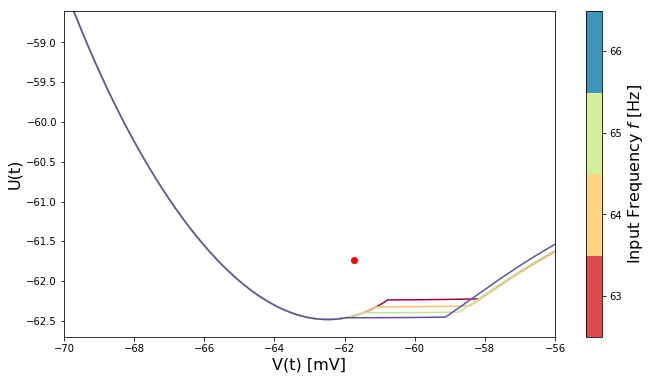

In [6]:


eigenfreq = 84 #TO DO
eigenperiod = 1000.0 / eigenfreq

l11 = True
l31 = False
l21 = False

dt = .01

if l11:
    freqs = np.arange(63, 67, 1) #for 8.0 and 130.1
if l31:
    freqs = np.arange(83, 95, 1)
if l21:
    freqs = np.arange(101, 108, 1) #for 130.1
    #freqs = np.arange(101, 108, 1) #for 8.0

ymax = -58.6
#xmax = -55.5
xmax = -56
xmin = -70
ymin = -62.7



min, max = (np.min(freqs), np.max(freqs))
if l11:
    mymap = plt.get_cmap('Spectral')
if l21:
   # mymap = plt.get_cmap('Wistia')
    mymap = plt.get_cmap('Spectral')
if l31:
    mymap = plt.get_cmap('Spectral')
#mymap = plt.get_cmap('gnuplot')
step = 1
Z = [[0,0],[0,0]]
levels = np.arange(min, max + step + 1, step)
#levels = range(min, max + step + 1, step)
CS3 = plt.contourf(Z, levels, cmap = mymap)
plt.clf()

fig = plt.figure(figsize=(11, 6))

for counter, f in enumerate(freqs, 0):
    color = mymap(0 + float(counter)/(len(freqs)-1))
    #color = mymap(.3)
    period = 1000.0 / f
    t, i, x = spikeresponse_trajec(kepler, 5.0, 131.5, f, True) #ef
    if counter == 0:
        print(x[1][9999 + 1 + int(43 * period/dt)])
      #  print(x[1][9999 + 1 + int(44 * period/dt)])
    if counter < len(freqs)  +1000:
        print(x[1][9999 + 1 + int(43 * period/dt)])
      #  print(x[1][9999 + 1 + int(44 * period/dt)])
 #   if l11:
 #       spikeinterval_start = int(10000+21*period/dt)
 #       spikeinterval_end = int(10000+22*period/dt)
    if l11:
        spikeinterval_start = int(10000+110.50*period/dt)
        spikeinterval_end = int(10000+111.50*period/dt)
        #spikeinterval_start = int(10000+31.70*period/dt)
        #spikeinterval_end = int(10000+32.70*period/dt)
    if l31:
        spikeinterval_start = int(10000+112.50*period/dt)
        spikeinterval_end = int(10000+115.50*period/dt)
        #spikeinterval_start = int(10000+31.70*period/dt)
        #spikeinterval_end = int(10000+34.70*period/dt)
    if l21:
        #spikeinterval_start = int(10000+39.3*period/dt)
        #spikeinterval_end = int(10000+41.3*period/dt)
        spikeinterval_start = int(10000+114.5*period/dt)
        spikeinterval_end = int(10000+116.5*period/dt)

    v_onespike = x[0][spikeinterval_start : spikeinterval_end]
    u_onespike = x[1][spikeinterval_start : spikeinterval_end]
    

    plt.xlabel('V(t) [mV]', fontsize = 16)
    plt.ylabel('U(t)', fontsize = 16)
    
    plt.plot(v_onespike, u_onespike, color = color)   
#plt.axis((-64.5, -60.0, -62.55, -62.25))

t1, i1, x1 = spikeresponse_trajec(kepler, 5.0, 5.0, 84, True)
fp_v = x1[0][10000]
fp_u = x1[1][10000]     
plt.plot(fp_v, fp_u, 'o', label = 'Stable Fixpoint', color = 'red')


cbar = fig.colorbar(CS3)
if l11:
    cbar.set_ticks((63.5, 64.5, 65.5, 66.5))
    cbar.set_ticklabels(("63", "64", "65", "66"))
if l31:
    cbar.set_ticks((83.5, 84.5, 85.5, 86.5, 87.5, 88.5, 89.5, 90.5, 91.5, 92.5, 93.5, 94.5))
    cbar.set_ticklabels(("83", "84", "85", "86", "87", "88", "89", "90", "91", "92", "93", "94"))
if l21:
    cbar.set_ticks((101.5, 102.5, 103.5, 104.5, 105.5, 106.5, 107.5))
    cbar.set_ticklabels(("101", "102", "103", "104", "105", "106", "107"))
    
cbar.set_label(r'Input Frequency $f$ [Hz]', fontsize = 16)

#plt.hlines(y=-62.57, xmin=-65.5, xmax=-59.0, color='r', linewidth = 3)
#plt.hlines(y=-61.47, xmin=-65.5, xmax=-59.0, color='r', linewidth = 3)
#plt.vlines(x=-65.47 , ymin=-62.50, ymax=-61.47, color='r', linewidth = 3)
#plt.vlines(x=-58.97, ymin=-62.53, ymax=-61.47, color='r', linewidth = 3)


#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
#plt.xlabel('V(t) [mV]', fontsize = 16)
plt.ylabel('U(t)', fontsize = 16)
plt.axis((xmin, xmax, ymin, ymax))
#plt.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    labelbottom=False)



#plt.legend(loc = 'upper right', frameon = False)
plt.savefig('BA_rec_11_delta.pdf')

In [ ]:
-61.2671824607
-59.4245124136
-61.3997126094
-58.8740390454

In [7]:

def spikeresponse_track2(derivative, I0, I1, freq) :
    #tmax = 10000.0
    #tmax = 600.0
    tmax = 2000.0
    dt = 0.01
    time = np.arange(int(tmax/dt))*dt #[ 0, dt, 2dt, ... , (tmax / dt) dt = tmax]
    thresh = -20.0
    taus = 1.0 #changed taus as an input
    stime = np.arange(0.0, .025 * taus, dt) #spiketime: [0, dt, 2dt, ..., 8taus] WHY 8?
    spulse = (I1-I0) + 0 * stime

    rates = [] #creates empty array
    dp = 1000.0/freq          #period = distance of pulses (= 1000 ms / frequency)
    pulses = np.arange(0.0, tmax-(1.5*taus), dp) #pulses occuring between 0 and tmax-8taus with dist. dp
    current = np.zeros(len(time)) + I0 #current = I0 for all the time
    for pt in pulses: #loop through all the pulse-times
        current[int(pt/dt):int(pt/dt)+len(spulse)] += spulse
            #add spulse (growth) while current is between pt and pt + 8tau/dt (= back at rest. pot)
            # = adds a full spulse on the current to the next pulse (dimensions are perfectly fit)
    t, i, x = trajectory(derivative, -100.0, tmax, I0, current, -65.0, -65.0)
        #...
    spikes = t[:-1][(x[0][:-1]<thresh) & (x[0][1:]>=thresh)]
        #array of times where value just jumps over threshhold
    spikes = spikes[spikes>1200.0] #only pick spikes, which occur for t>100ms
    rate = 0.0
    if len(spikes) > 2: #more han two spikes occur
        rate = 1000.0*(len(spikes)-1)/(spikes[-1]-spikes[0]) #
    rates.append(rate) #put all rate together in rates (evaluate one rate per frequency)
    
    #return np.round(rate/freq, 2)

    
    #return t[10000:], x, i[10000:]
    return rate/freq

In [26]:
for f in (62, 63, 66, 67):
    print(spikeresponse_track2(kepler, 5.0, 131.5, f))
    

0.0
1.0000100001
0.999983529683
0.864437225433
